In [1]:
import matplotlib.pyplot as plt

In [2]:
import numpy as np

# Single Phase Linear Solver
The Simulator is structured into six main stages, each contributing to an efficient and accurate reservoir simulation process. The workflow ensures modularity, ease of debugging, and scalability while maintaining computational efficiency.

1. Input Data
2. Gridding
3. Property Calculation
4. Configuration
5. Simulation
6. Post-Processing

This structured workflow ensures a systematic approach to reservoir simulation, allowing for improved accuracy, efficiency, and adaptability. The modular design enables easy integration of additional physics, optimization routines, and extended functionalities.

## Input Data
This stage involves reading and parsing all necessary input parameters required for the simulation. These include:
- Grid properties (geometry and dimensions)
- Reservoir rock properties (porosity, permeability, depth, etc.)
- Fluid properties (PVT data, viscosity, compressibility, etc.)
- Well constraints (rates, pressures, productivity index, etc.)
- Numerical control parameters (tolerances, max iterations, etc.)
- Boundary and initial conditions (pressure and saturation distributions)

Grid Properties:

In [3]:
xdelta = np.array([750,1000,1250])
ydelta = np.array([750,1000,1250])
zdelta = 20

Reservoir Rock Properties:

In [4]:
xperm = np.array([50,100,200,100,150,250,150,200,300])
yperm = xperm/2
zperm = xperm/10

In [5]:
poro = np.array([0.15,0.18,0.20,0.17,0.20,0.22,0.22,0.25,0.26])

Fluid Properties

In [6]:
visc = 5

In the notebook, class interfaces are designed to follow oilfield units, while the only underscored property is kept in SI units for computational purposes.

## Gridding
The simulator constructs a computational grid to represent the reservoir. This process includes:
- Defining grid dimensions and discretization (structured grids)
- Generating neighboring connectivity and indexing for efficient computations

To achieve the interface objective, we first define a base Grid class that serves as the interface for a user:

In [7]:
class GridBase():

	def __init__(self,xdelta,ydelta,zdelta):
		"""Initialize grid deltas in feet. Internally stored in meters."""
		self.xdelta = xdelta # ft
		self.ydelta = ydelta # ft
		self.zdelta = zdelta # ft
		
	@property
	def xdelta(self):
		return self._xdelta/0.3048

	@xdelta.setter
	def xdelta(self,value):
		self._xdelta = np.asarray(value).flatten().astype(np.float64)*0.3048

	@property
	def ydelta(self):
		return self._ydelta/0.3048

	@ydelta.setter
	def ydelta(self,value):
		self._ydelta = np.asarray(value).flatten().astype(np.float64)*0.3048

	@property
	def zdelta(self):
		return self._zdelta/0.3048

	@zdelta.setter
	def zdelta(self,value):
		self._zdelta = np.asarray(value).flatten().astype(np.float64)*0.3048

Next, we define a Grid class that inherits from GridBase and is utilized by the solver's assembler.

In [8]:
class Grid(GridBase):

    def __init__(self,plat,xdelta,ydelta,zdelta):        
        super().__init__(xdelta,ydelta,zdelta)
        self.plat = plat
        self.volume = None

    @property
    def nums(self):
        """Returns total number of grids."""
        return self.plat.shape[0]

    @property
    def dims(self):
        return int(self.plat.shape[1]/2)

    @property
    def index(self):
        return np.arange(self.nums)

    @property
    def volume(self):
        return self._volume*35.3147

    @volume.setter
    def volume(self,value):
        self._volume = np.prod((self._xdelta,self._ydelta,self._zdelta),axis=0)

Finally, we define the GridDelta class, which returns an instance of the Grid class when referenced.

In [9]:
class GridDelta(GridBase):
	"""Gridding based on delta values."""
	def __init__(self,xdelta,ydelta,zdelta):
		super().__init__(xdelta,ydelta,zdelta)	

	@property
	def nums(self):
		"""Returns tuple of (xnums,ynums,znums)."""
		return (self.xnums,self.ynums,self.znums)

	@property
	def xnums(self):
		return self._xdelta.size

	@property
	def ynums(self):
		return self._ydelta.size

	@property
	def znums(self):
		return self._zdelta.size

	@property
	def dims(self) -> int:
		"""Returns the number of dimensions based on self.nums."""
		return next((i+1 for i in range(2,-1,-1) if self.nums[i]>1),1)

	@property
	def index(self):
		return np.arange(np.prod(self.nums))

	@property
	def grid(self):

		xdelta = np.tile(self.xdelta,self.ynums*self.znums)
		ydelta = np.tile(np.repeat(self.ydelta,self.xnums),self.znums)
		zdelta = np.repeat(self.zdelta,self.xnums*self.ynums)

		return Grid(self.plat,xdelta,ydelta,zdelta)

	@property
	def plat(self):
		"""Plat of grids that locates neighbor index information."""
		map_ = np.tile(self.index,(self.dims*2,1)).T

		map_[self.index.reshape(-1,self.xnums)[:,1:].ravel(),0] -= 1
		map_[self.index.reshape(-1,self.xnums)[:,:-1].ravel(),1] += 1

		if self.dims>1:
			map_[self.index.reshape(self.znums,-1)[:,self.xnums:],2] -= self.xnums
			map_[self.index.reshape(self.znums,-1)[:,:-self.xnums],3] += self.xnums

		if self.dims>2:
			map_[self.index.reshape(self.znums,-1)[1:,:],4] -= self.xnums*self.ynums
			map_[self.index.reshape(self.znums,-1)[:-1,:],5] += self.xnums*self.ynums

		return map_

Now, let us utilize the GridDelta class with the provided input data.

In [10]:
delta = GridDelta(xdelta,ydelta,20)

In [11]:
delta.xdelta

array([ 750., 1000., 1250.])

In [12]:
delta.ydelta

array([ 750., 1000., 1250.])

In [13]:
delta.dims

2

In [14]:
delta.grid.dims

2

In [15]:
delta.grid.volume

array([11250010.60135316, 15000014.13513754, 18750017.66892192,
       15000014.13513754, 20000018.84685005, 25000023.55856256,
       18750017.66892192, 25000023.55856256, 31250029.4482032 ])

In [16]:
delta.index

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [17]:
delta.plat

array([[0, 1, 0, 3],
       [0, 2, 1, 4],
       [1, 2, 2, 5],
       [3, 4, 0, 6],
       [3, 5, 1, 7],
       [4, 5, 2, 8],
       [6, 7, 3, 6],
       [6, 8, 4, 7],
       [7, 8, 5, 8]])

## Reservoir Rock and Fluid Property Calculation
In general, this step determines essential reservoir rock and fluid properties at each grid block. It includes:
- Permeability and porosity of the grids
- Rock compressibility adjustments for pressure variations
- Relative permeability and capillary pressure calculations
- Black oil PVT calculations (formation volume factor, solution gas-oil ratio, etc.)

We define the PorMed class, which encapsulates all the rock properties required for reservoir simulation with the interface objective in mind.

In [18]:
class PorMed():
    
    def __init__(self,xperm,poro=None,**kwargs):

        self.set_perm(xperm,**kwargs)
        
        self.poro = poro # fraction
        
    @property
    def perm(self):
        return self._perm/9.869233e-16
        
    def set_perm(self,xperm,*,yperm=None,zperm=None,yreduce:float=1.,zreduce:float=10.):
        """Assigns the permeability values in mD to the grids.
    
        xperm 	: permeability in x-direction, mD
        yperm   : permeability in y direction, mD
        zperm   : permeability in z direction, mD
    
        yreduce : xperm to yperm ratio, dimensionless
        zreduce : xperm to zperm ratio, dimensionless
    
        """
        self.xperm = xperm
        self.yperm = (yperm,yreduce)
        self.zperm = (zperm,zreduce)

        self._perm = np.column_stack((self._xperm,self._yperm,self._zperm))

    @property
    def xperm(self):
        return self._xperm/9.869233e-16

    @xperm.setter
    def xperm(self,value):
        self._xperm = value*9.869233e-16

    @property
    def yperm(self):
        return self._yperm/9.869233e-16

    @yperm.setter
    def yperm(self,value):
        self._yperm = self._xperm/value[1] if value[0] is None else value[0]*9.869233e-16
    
    @property
    def zperm(self):
        return self._zperm/9.869233e-16

    @zperm.setter
    def zperm(self,value):
        self._zperm = self._xperm/value[1] if value[0] is None else value[0]*9.869233e-16

    @property
    def poro(self):
        return self._poro
        
    @poro.setter
    def poro(self,value):
        self._poro = value

Now, let us utilize the PorMed class with the provided input data.

In [19]:
res = PorMed(xperm,yperm=yperm,zperm=zperm,poro=poro)

In [20]:
res.xperm

array([ 50., 100., 200., 100., 150., 250., 150., 200., 300.])

In [21]:
res.yperm

array([ 25.,  50., 100.,  50.,  75., 125.,  75., 100., 150.])

In [22]:
res.poro

array([0.15, 0.18, 0.2 , 0.17, 0.2 , 0.22, 0.22, 0.25, 0.26])

### Fluid Properties

The only fluid property important for now is the viscosity

In [23]:
class Fluid():

  def __init__(self,visc):
    self.visc = visc # cp

  @property
  def visc(self):
    return self._visc*1000

  @visc.setter
  def visc(self,value):
    self._visc = value/1000

Utilizing the class for the exercise

In [24]:
oil = Fluid(visc=5)

In [25]:
oil.visc

5.0

## Configuration
Before running the simulation, the system needs initialization and setup:
- Establishing initial reservoir conditions (pressure and saturation distributions)
- Setting up time stepping
- Defining well configurations and operating constraints (BHP control, rate control, etc.)
- Assigning production and injection schedules

Below we configure time settings:

In [26]:
class Time():
	"""Time class for the reservoir simulation"""
	def __init__(self,delta:float,total:float):
		"""Defining the time settings for the simulator

		delta   : first time step defined in days
		total   : total simulation time defined in days
		"""

		self.delta = delta
		self.total = total

		self.times = None
		self.steps = None

	@property
	def delta(self):
		return self._delta/(24*60*60)

	@delta.setter
	def delta(self,value):
		self._delta = value*24*60*60

	@property
	def total(self):
		return self._total/(24*60*60)

	@total.setter
	def total(self,value):
		self._total = value*24*60*60

	@property
	def times(self):
		return self._times/(24*60*60)

	@times.setter
	def times(self,value):
		"""Sets linearly spaced time data."""
		self._times = np.arange(
			self._total+self._delta/2,step=self._delta)

	@property
	def steps(self):
		return self._steps/(24*60*60)

	@steps.setter
	def steps(self,value):
		"""Sets the time steps in the given time array."""
		self._steps = self._times[1:]-self._times[:-1]

	def __iter__(self):
		"""It starts from 0 time and iterates till the last time step."""

		zipped = zip(self._times,self._steps)

		for index,(time,step) in enumerate(zipped):

			yield index,time,step

	@property
	def nums(self):
		return self._steps.size

In [27]:
time = Time(1,5)

In [28]:
time.total

5.0

In [29]:
time.steps

array([1., 1., 1., 1., 1.])

In [30]:
time.nums

5

In [31]:
for index,current,step in time:
    print(index,current,step)

0 0.0 86400.0
1 86400.0 86400.0
2 172800.0 86400.0
3 259200.0 86400.0
4 345600.0 86400.0


## Simulation
The core of the simulator solves the governing equations for mass conservation and flow dynamics. This involves:
- Computing block-centered and inter-block transmissibilities
- Applying the appropriate numerical scheme (fully implicit, explicit, or IMPES hybrid approach)
- Constructing linearized system matrices
- Solving the system using direct or iterative solvers
- Updating properties and advancing in time

First, we define a Matrix class that facilitates interaction between the builder and the solver:

In [32]:
class Matrix():

    def __init__(self,T:np.ndarray,J:np.ndarray,A:np.ndarray,Q:np.ndarray,G:np.ndarray):
        """
        T   : Inter-block transmissibility, matrix
        J   : Productivity index, diagonal matrix
        A   : Block accumulation, diagonal matrix
        Q   : Source term, vector
        G   : Gravity term, vector
        """
        self.T = T # transmissibility
        self.J = J # productivity
        self.A = A # block accumulation
        self.Q = Q # source
        self.G = G # gravity

    @property
    def T(self):
        """Converting from SI Units to Oil Field Units."""
        return self._T*(3.28084**3)*(24*60*60)*6894.76

    @T.setter
    def T(self,value):
        self._T = value/((3.28084**3)*(24*60*60)*6894.76)

    @property
    def J(self):
        """Converting from SI Units to Oil Field Units."""
        return self._J*(3.28084**3)*(24*60*60)*6894.76

    @J.setter
    def J(self,value):
        self._J = value/((3.28084**3)*(24*60*60)*6894.76)
        
    @property
    def A(self):
        """Converting from SI Units to Oil Field Units."""
        return self._A*(3.28084**3)*(24*60*60)

    @A.setter
    def A(self,value):
        self._A = value/((3.28084**3)*(24*60*60))

    @property
    def Q(self):
        """Converting from SI Units to Oil Field Units."""
        return self._Q*(3.28084**3)*(24*60*60)

    @Q.setter
    def Q(self,value):
        self._Q = value/((3.28084**3)*(24*60*60))

    @property
    def G(self):
        """Converting from SI Units to Oil Field Units."""
        return self._G*(3.28084**3)*(24*60*60)

    @G.setter
    def G(self,value):
        self._G = value/((3.28084**3)*(24*60*60))

### Block Calculations

Block calculations are performed for transmissibility and storativity.

In [33]:
class Block():

    def __init__(self,grid,res,fluid,*args):

        self.grid = grid
        self.res = res
        self.fluid = fluid
        self.wells = args

    def transmissibility(self):
        self._Tx = self.res._xperm*self.grid._ydelta*self.grid._zdelta/self.grid._xdelta/self.fluid._visc
        self._Ty = self.res._yperm*self.grid._zdelta*self.grid._xdelta/self.grid._ydelta/self.fluid._visc
        self._Tz = self.res._zperm*self.grid._xdelta*self.grid._ydelta/self.grid._zdelta/self.fluid._visc

    @property
    def Tx(self):
        return self._Tx*(3.28084**3)*(24*60*60)*6894.76
    
    @property
    def Ty(self):
        return self._Ty*(3.28084**3)*(24*60*60)*6894.76
    
    @property
    def Tz(self):
        return self._Tz*(3.28084**3)*(24*60*60)*6894.76

    def accumulation(self,tdelta:float):
        self._A = (self.grid._volume*self.res._poro)/(tdelta*86400)
        
    @property
    def A(self):
        return self._A*(3.28084**3)*(24*60*60)

    def productivity(self):

        self._J = []

        for well in self.wells:
            
            if well.axis=="x":
                k1 = self.res._yperm[list(well.block)]
                k2 = self.res._zperm[list(well.block)]
                w1 = self.grid._ydelta[list(well.block)]
                w2 = self.grid._zdelta[list(well.block)]
                w3 = self.grid._xdelta[list(well.block)]
            elif well.axis=='y':
                k1 = self.res._xperm[list(well.block)]
                k2 = self.res._zperm[list(well.block)]
                w1 = self.grid._xdelta[list(well.block)]
                w2 = self.grid._zdelta[list(well.block)]
                w3 = self.grid._ydelta[list(well.block)]
            elif well.axis=='z':
                k1 = self.res._xperm[list(well.block)]
                k2 = self.res._yperm[list(well.block)]
                w1 = self.grid._xdelta[list(well.block)]
                w2 = self.grid._ydelta[list(well.block)]
                w3 = self.grid._zdelta[list(well.block)]
    
            req = self.requivalent(k1,k2,w1,w2)
        
            self._J.append(2*np.pi*w3*np.sqrt(k1*k2)/(self.fluid._visc*(np.log(req/well._radius)+well.skin)))

    @property
    def J(self):
        return [j*(3.28084**3)*(24*60*60)*6894.76 for j in self._J]

    @staticmethod
    def requivalent(perm1,perm2,edge1,edge2):
        """Returns equivalent radius of grids that contains well."""
        sqrt21 = np.power(perm2/perm1,1/2)*np.power(edge1,2)
        sqrt12 = np.power(perm1/perm2,1/2)*np.power(edge2,2)

        quar21 = np.power(perm2/perm1,1/4)
        quar12 = np.power(perm1/perm2,1/4)

        return 0.28*np.sqrt(sqrt21+sqrt12)/(quar21+quar12)

In [ ]:
print(Block.requivalent(w1,delta.grid,res))
print(Block.requivalent(w2,delta.grid,res))

Integrating the grid, reservoir, and oil properties into the block calculation:

In [34]:
block = Block(delta.grid,res,oil)
block.transmissibility()
block.storativity(1)

In [35]:
block.Tx

array([1.26565812, 1.89848718, 3.03757949, 3.37508832, 3.79697436,
       5.06263248, 6.32829061, 6.32829061, 7.59394873])

In [36]:
block.Ty

array([0.63282906, 1.68754416, 4.2188604 , 0.94924359, 1.89848718,
       3.95518163, 1.13909231, 2.02505299, 3.79697436])

In [37]:
block.Tz

array([ 177.98317328,  474.62179542, 1186.55448854,  474.62179542,
        949.24359084, 1977.59081424,  889.91586641, 1582.07265139,
       2966.38622136])

In [38]:
block.accumulation

array([ 337500.0324    ,  540000.05184   ,  750000.072     ,
        510000.04896   ,  800000.0768    , 1100000.1056    ,
        825000.0792    , 1250000.12      , 1625000.15600001])

### Building Matrices

Next, we define a Build class that constructs the matrices to be used in the solver.

In [39]:
class Build():

    def __init__(self,plat):
        self.plat = plat

    @property
    def nums(self):
        return self.plat.shape[0]

    @property
    def dims(self):
        return int(self.plat.shape[1]/2)

    @property
    def index(self):
        return np.arange(self.nums)

    def T(self,Tx,Ty,Tz):

        index = self.index
        
        T = np.zeros((self.nums,self.nums))

        Sxneg = index[self.plat[:,0]!=index]
        Nxneg = self.plat[self.plat[:,0]!=index,0]

        txneg = Build.harmonic_mean(Tx[Sxneg],Tx[Nxneg])
        
        T[Sxneg,Nxneg] -= txneg
        T[Sxneg,Sxneg] += txneg
        
        Sxpos = index[self.plat[:,1]!=index]
        Nxpos = self.plat[self.plat[:,1]!=index,1]

        txpos = Build.harmonic_mean(Tx[Sxpos],Tx[Nxpos])
        
        T[Sxpos,Nxpos] -= txpos
        T[Sxpos,Sxpos] += txpos
        
        Syneg = index[self.plat[:,2]!=index]
        Nyneg = self.plat[self.plat[:,2]!=index,2]

        tyneg = Build.harmonic_mean(Ty[Syneg],Ty[Nyneg])

        T[Syneg,Nyneg] -= tyneg
        T[Syneg,Syneg] += tyneg
        
        Sypos = index[self.plat[:,3]!=index]
        Nypos = self.plat[self.plat[:,3]!=index,3]

        typos = Build.harmonic_mean(Ty[Sypos],Ty[Nypos])

        T[Sypos,Nypos] -= typos
        T[Sypos,Sypos] += typos

        return T

    def A(self,accumulation):

        A = np.zeros((self.nums,self.nums))

        A[self.index,self.index] = accumulation

        return A

    @staticmethod
    def harmonic_mean(term1,term2):
        """Returns harmonic mean of two terms, term1 and term 2."""
        return (2*term1*term2)/(term1+term2)

In [40]:
build = Build(block.grid.plat)

In [41]:
T = build.T(block.Tx,block.Ty,block.Tx); T

array([[ 2.27818462, -1.51878975,  0.        , -0.75939487,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [-1.51878975,  5.64220082, -2.33659961,  0.        , -1.78681147,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        , -2.33659961,  6.41936774,  0.        ,  0.        ,
        -4.08276813,  0.        ,  0.        ,  0.        ],
       [-0.75939487,  0.        ,  0.        ,  5.36855627, -3.57362293,
         0.        , -1.03553846,  0.        ,  0.        ],
       [ 0.        , -1.78681147,  0.        , -3.57362293, 11.65956237,
        -4.33939927,  0.        , -1.9597287 ,  0.        ],
       [ 0.        ,  0.        , -4.08276813,  0.        , -4.33939927,
        12.29663104,  0.        ,  0.        , -3.87446364],
       [ 0.        ,  0.        ,  0.        , -1.03553846,  0.        ,
         0.        ,  7.36382907, -6.32829061,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        , -1

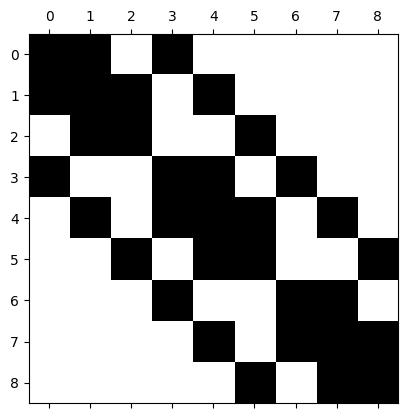

In [42]:
plt.spy(T); plt.show()

In [43]:
A = build.A(block.accumulation); A

array([[ 337500.0324    ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ],
       [      0.        ,  540000.05184   ,       0.        ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,  750000.072     ,
              0.        ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        ,
         510000.04896   ,       0.        ,       0.        ,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        ,
              0.        ,  800000.0768    ,       0.        ,
              0.        ,       0.        ,       0.        ],
       [      0.        ,       0.        ,       0.        ,
   

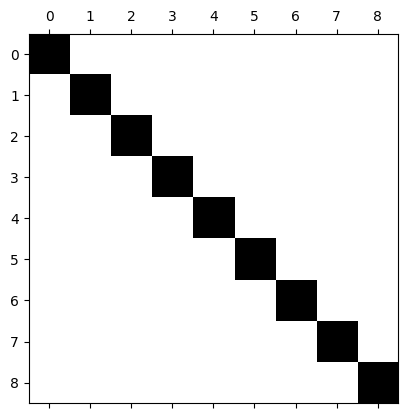

In [44]:
plt.spy(A); plt.show()

## Post-Processing: Visualization
Once the simulation is complete, results are processed and visualized for interpretation:
- Generating pressure, saturation, and production rate plots
- Creating well performance summaries (BHP, oil/gas/water production rates)
- Producing field-scale 2D/3D visualizations for analysis
- Exporting results for further interpretation and reporting